# **Job title classification**

Groupe : Dupuy-Zini Alexandre & Ghermi Ridouane

---

# **Introduction**

Grouping jobs by theme is important to bring job offers and candidates together. However, everyone is free to use the terms they wish to describe a job. The *ROME (Répertoire Opérationnel des Métiers et Emplois)* job directory is therefore built as a tool to formalize the designation of skills. We wish to know if it is possible to predict the class of a job from its name, or even to predict a classification for an alternative name or for a new job.

We will use data from the Répertoire Opérationnel des Métiers et des Emplois available and explained here: https://www.pole-emploi.org/opendata/repertoire-operationnel-des-meti.html?type=article

We will first explore the whole inventory, then build different classifiers from the simplest to the more advanced. As there are several levels of more or less generic job categories, we will observe the performances on these different levels. We will test the models quantitatively and qualitatively. Finally, we will draw conclusions from our work and discuss possible extensions.

## Imports and utils

In [ ]:
!pip install sentencepiece -q
!pip install transformers -q

     |████████████████████████████████| 1.2MB 19.6MB/s 
     |████████████████████████████████| 2.2MB 21.5MB/s 
     |████████████████████████████████| 3.3MB 55.9MB/s 
     |████████████████████████████████| 870kB 48.5MB/s 


In [ ]:
import random
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

from gensim import corpora
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def print_scores(y_test, y_preds, predictions):
  print("micro f1_score:    %0.3f " % f1_score(y_test, y_preds, average="micro"))
  print("macro f1_score:    %0.3f " % f1_score(y_test, y_preds, average="macro"))
  print("weighted f1_score: %0.3f " % f1_score(y_test, y_preds, average="weighted"))
  print("logloss:           %0.3f " % multiclass_logloss(y_test, predictions))
  print("accuracy:          %0.3f " % accuracy_score(y_test, y_preds))

def print_scores_models(models, x_train, x_test, y_train, y_test):
  items_list = ["micro f1_score", "macro f1_score", "weighted f1_score", "logloss", "accuracy"]
  models_names = [type(m).__name__ for m in models]
  data = np.zeros((5, len(models)))

  clf_list = []

  for i, clf in enumerate(models):
    clf.fit(x_train, y_train)
    y_preds = clf.predict(x_test)
    predictions = clf.predict_proba(x_test)
    data[0, i] = f1_score(y_test, y_preds, average="micro")
    data[1, i] = f1_score(y_test, y_preds, average="macro")
    data[2, i] = f1_score(y_test, y_preds, average="weighted")
    data[3, i] = multiclass_logloss(y_test, predictions)
    data[4, i] = accuracy_score(y_test, y_preds)
    clf_list.append(clf)

  title_format = "{:>20}"+"|{:>25}" * len(models)
  row_format ="{:>20}"+"|{:25.3f}" * len(models)
  print(title_format.format("", *models_names))
  for team, row in zip(items_list, data):
      print(row_format.format(team, *row))
  return clf_list

def tsne_embeddings(embedded_docs):
  points_0 = pd.DataFrame(TSNE(n_components=2).fit_transform(embedded_docs))
  points_0['target'] = df.code_grand_domaine

  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Component 1', fontsize = 15)
  ax.set_ylabel('Component 2', fontsize = 15)

  targets = df.code_grand_domaine.unique()
  colors_list = list(colors._colors_full_map.values())[:len(targets)]
  for target, color in zip(targets, colors_list):
      indicesToKeep = points_0['target'] == target
      ax.scatter(points_0.loc[indicesToKeep, 0], points_0.loc[indicesToKeep, 1], c = color, s = 25)
  ax.legend(targets)
  ax.grid()

def print_new_jobs(embedded_new_job_titles, new_job_titles, new_job_titles_expected, clf_list):
  print("*** Expected ***")
  for i, job_title in enumerate(new_job_titles):
      print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == new_job_titles_expected[i]].libelle_grand_domaine.values[0]))
  print("\n")

  for clf in clf_list:
    print(f"--- {type(clf).__name__} ---")
    labels = encoder.inverse_transform(clf.predict(embedded_new_job_titles))
    for i, job_title in enumerate(new_job_titles):
      print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == labels[i]].libelle_grand_domaine.values[0]))
    print("\t Success rate : {}/{}".format(sum(np.array(labels) == np.array(new_job_titles_expected)), len(labels)))
    print("\n")

# **1. Data acquisition and exploration**

In this section, we download a directory composed of all the necessary files to explore the subject. Several `csv` files enable to enable to understand the structure and construction logic of the classification tree, which is decomposed in 3 levels, according to the following hierarchy:
* 14 large domains
* 110 professionnal domains
* 532 ROME codes

Finally, the leaves of this tree are grouping of similar jobs under the same precise denomination. Those are the documents that we wish to classify at best in the different tree classification levels.

In [ ]:
!wget -q https://api.emploi-store.fr/api/docs/romeopen/REF_ROME_CSV/1/RefRomeCsv.zip
!unzip -q RefRomeCsv.zip

## **1.1 Textual description of the ROME codes**

Among the downloaded files, the following one attributes one or more textual descriptions for each ROME code. This could be useful for later computations.

In [ ]:
df_texte = pd.read_csv("unix_texte_v346_utf8.csv")
print(df_texte.shape)
df_texte[df_texte.libelle_type_texte == "definition"][["code_rome", "libelle_texte"]].sample(5)

(5050, 5)


,code_rome,libelle_texte
525,G1401,Peut participer à l''accueil et au service des...
209,C1206,"Assure le conseil, la promotion et la vente de..."
930,J1104,Peut diriger un cabinet.
672,H2208,Peut coordonner une équipe et diriger une stru...
616,H1401,"Organise et supervise l''ordonnancement, la pl..."


## **1.2 Tree structure**

In the next 3 files, short texts are associated to each category of the 3 tree levels. Here we can witness the gradual progression of accuracy in the description as the number of categories is increased.

In [ ]:
df_niv1 = pd.read_csv("unix_grand_domaine_v346_utf8.csv")
print(df_niv1.shape)
df_niv1.sample(5)

(14, 2)


,code_grand_domaine,libelle_grand_domaine
7,H,Industrie
9,J,Santé
1,B,Arts et Façonnage d'ouvrages d'art
3,D,"Commerce, Vente et Grande distribution"
0,A,"Agriculture et Pêche, Espaces naturels et Espa..."


In [ ]:
df_niv2 = pd.read_csv("unix_domaine_professionnel_v346_utf8.csv")
print(df_niv2.shape)
df_niv2.sample(5)

(110, 2)


,code_domaine_professionnel,libelle_domaine_professionnel
78,K18,Développement territorial et emploi
71,K11,Accompagnement de la personne
65,I16,"Véhicules, engins, aéronefs"
91,M11,Achats
23,E11,Edition et communication


In [ ]:
df_niv3 = pd.read_csv("unix_referentiel_code_rome_v346_utf8.csv")
print(df_niv3.shape)
df_niv3[["code_rome", "libelle_rome"]].sample(5)

(532, 5)


,code_rome,libelle_rome
413,K2203,Management et inspection en propreté de locaux
357,J1507,Soins infirmiers spécialisés en puériculture
21,A1413,Fermentation de boissons alcoolisées
62,C1204,Conception et expertise produits bancaires et ...
69,C1401,Gestion en banque et assurance


Moreover, this latter file helps understand the way that the tree is built. In particular, the ROME code is the concatenation of the 3 levels codes of the job.

In [ ]:
df_tree = pd.read_csv("unix_cr_gd_dp_v346_utf8.csv")
print(df_tree.shape)
df_tree.sample(5)

(532, 6)


,code_rome,libelle_rome,code_grand_domaine,libelle_grand_domaine,code_domaine_professionel,libelle_domaine_professionel
363,K1202,Éducation de jeunes enfants,K,Services à la personne et à la collectivité,K12,"Action sociale, socio-éducative et socio-cultu..."
275,H2904,Conduite d'équipement de déformation des métaux,H,Industrie,H29,"Mécanique, travail des métaux et outillage"
214,H1209,Intervention technique en études et développem...,H,Industrie,H12,"Conception, recherche, études et développement"
236,H2206,Réalisation de menuiserie bois et tonnellerie,H,Industrie,H22,Bois
441,L1501,Coiffure et maquillage spectacle,L,Spectacle,L15,Techniciens du spectacle


## **1.3 Jobs directory**

Then, this file contains the 11112 job labelings, the majority of which are in the masculine and feminine forms at the same time.

In [ ]:
df_jobs = pd.read_csv("unix_referentiel_appellation_v346_utf8.csv")
df_jobs[["code_rome", "libelle_appellation_long"]]

,code_rome,libelle_appellation_long
0,F1402,Abatteur / Abatteuse de carrière
1,I1601,Accastilleur-gréeur / Accastilleuse-gréeuse
2,I1601,Accastilleur-monteur / Accastilleuse-monteuse ...
3,L1503,Accessoiriste
4,L1503,Accessoiriste de plateau
...,...,...
11107,M1805,Développeur / Développeuse back-end
11108,M1806,Project Management Officer - PMO
11109,C1205,Conseiller / Conseillère en gestion de patrimo...
11110,K1802,Manager de centre-ville


Here is an example of a ROME code with the associated job and category.

In [ ]:
code, texte = df_jobs.sample()[["code_rome", "libelle_appellation_long"]].values[0]
cat = df_niv3[df_niv3.code_rome == code]["libelle_rome"].values[0]
print(code, texte)
print(cat)

E1402 Web planneur / planneuse
Élaboration de plan média


## **1.4 Dataset generation**

Finally, we generate in the next cells the dataset that will be useful the following experimentations. It is built from the name of the job, and its 3 levels of categories.

In [ ]:
df = df_jobs[["libelle_appellation_long", "code_rome"]]

In [ ]:
df["code_domaine_professionel"] = df["code_rome"].apply(lambda x: x[:3])
df["code_grand_domaine"] = df["code_rome"].apply(lambda x: x[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,libelle_appellation_long,code_rome,code_domaine_professionel,code_grand_domaine
0,Abatteur / Abatteuse de carrière,F1402,F14,F
1,Accastilleur-gréeur / Accastilleuse-gréeuse,I1601,I16,I
2,Accastilleur-monteur / Accastilleuse-monteuse ...,I1601,I16,I
3,Accessoiriste,L1503,L15,L
4,Accessoiriste de plateau,L1503,L15,L


## **1.5 Some statistics**

Here, we can notice that the labels are unbalanced. This can be verified for any level of the tree, but we present here only for the large domain level.

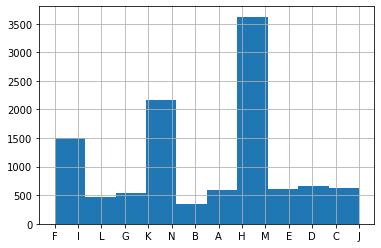

In [ ]:
df["code_grand_domaine"].hist() # other columns : code_rome, code_domaine_professionel

In [ ]:
word_counts_uncleaned = Counter(" ".join(df.libelle_appellation_long.apply(lambda x: x.lower()).values).split())
most_common_uncleaned = df.groupby("code_grand_domaine").apply(lambda subf: Counter(" ".join(subf.libelle_appellation_long.apply(lambda x: x.lower()).values).split()).most_common(5))
most_common_uncleaned

code_grand_domaine
A    [(/, 476), (de, 207), (en, 86), (ouvrier, 65),...
B    [(/, 286), (en, 62), (de, 57), (à, 29), (sur, ...
C    [(/, 259), (de, 174), (en, 108), (assurances, ...
D    [(/, 533), (de, 328), (en, 224), (vendeur, 155...
E    [(/, 436), (de, 256), (en, 117), (conducteur, ...
F    [(/, 677), (de, 335), (en, 104), (conducteur, ...
G    [(/, 434), (de, 397), (en, 68), (animateur, 55...
H    [(/, 2298), (de, 1475), (en, 1457), (industrie...
I    [(/, 596), (de, 476), (en, 232), (maintenance,...
J    [(/, 166), (de, 82), (en, 47), (infirmier, 37)...
K    [(/, 1185), (de, 899), (en, 169), (des, 131), ...
L    [(/, 349), (de, 132), (spectacle, 49), (chef, ...
M    [(/, 601), (de, 365), (responsable, 174), (des...
N    [(/, 459), (de, 397), (conducteur, 78), (condu...
dtype: object

In [ ]:
word_counts_uncleaned.most_common(10)

[('/', 8755),
 ('de', 5580),
 ('en', 2822),
 ('responsable', 715),
 ('chef', 670),
 ('technicien', 665),
 ('technicienne', 665),
 ('et', 663),
 ('industrie', 603),
 ('des', 599)]

In [ ]:
print(f"Number of unique words : {len(word_counts_uncleaned)}")

Number of unique words : 7294


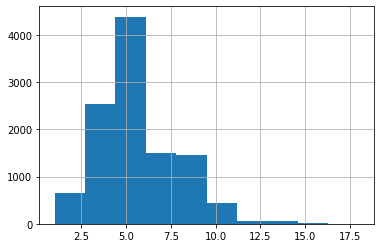

In [ ]:
df.libelle_appellation_long.apply(lambda x: len(x.split())).hist()

Not a lot of repeated words across a single labeling, mostly stopwords to eliminate

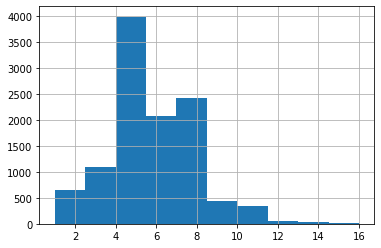

In [ ]:
df.libelle_appellation_long.apply(lambda x: len(np.unique(x.lower().split()))).hist()

Although we can notice that some job names are written for both genders, there is no clear and easy rule to separate the two writtings. For example, the names `"Technicien détecteur navigateur aérien / Technicienne détectrice navigatrice aérienne de l'armée"`, `Ouvrier portuaire débardeur / Ouvrière portuaire débardeuse` and `"Exploitant / Exploitante d'attractions"`, respond to different constructions that would require too much work to separate into two pieces.

Therefore, they are considered as is to avoid deleting some information by error during the process, even if it risks to focus the sentences meaning on the similar words of the genders declination.

The following cell shows the distribution of words before a ` /` which separates the two writings.

In [ ]:
df.libelle_appellation_long.apply(lambda x: len(x.split(" /")[0].split()) if len(x.split(" /"))>1 else 0).value_counts()

1    7333
0    2381
2    1238
3     118
4      38
5       4
Name: libelle_appellation_long, dtype: int64

## **1.6 Metric choice**

As the problem focuses on a multiclass classification with a high number of classes, there is a need for a clear and easy point of comparison. The most common ones are the micro, macro and weighted f1_score. Multiclass LogLoss is another option when all the prediction probabilities are important, whereas the f1_score will only toake account for the hightest probability class.

Still, one can qualitatively assess the performance of the models by manually testing some job denominations using for example synonyms.

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

# **2. Pre-processing**

Before building any model, let's further explore the dataset and apply some preprocessing once for all the following models.

## **2.1 Pre-processing**

In [ ]:
# Encode label
encoder = preprocessing.LabelEncoder()
df['code_grand_domaine'] = encoder.fit_transform(df.code_grand_domaine.values)
df['raw_text'] = df.libelle_appellation_long

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def lowerize(docs):
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()
    return docs
def tokenize(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = tokenizer.tokenize(docs[idx])
    return docs
def remove_stop_words(docs):
    stop_words = set(stopwords.words('french'))
    for idx in range(len(docs)):
        docs[idx] = [w for w in docs[idx] if not w in stop_words]
    return docs
def remove_word_with_length(docs, length=1):
    # Remove words that are only (length=1) character.
    docs = [[token for token in doc if len(token) > length] for doc in docs]
    return docs
def lemmatize(docs):
    # Lemmatize the documents
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs

In [ ]:
# Pre-process text
with pd.option_context('mode.chained_assignment', None):
    df['libelle_appellation_long'] = lowerize(df.libelle_appellation_long)
    df['libelle_appellation_long'] = tokenize(df.libelle_appellation_long)
    df['libelle_appellation_long'] = remove_stop_words(df.libelle_appellation_long)
    df['libelle_appellation_long'] = remove_word_with_length(df.libelle_appellation_long)
    df['libelle_appellation_long'] = lemmatize(df.libelle_appellation_long)

In [ ]:
df.head()

,libelle_appellation_long,code_rome,code_domaine_professionel,code_grand_domaine,raw_text
0,"[abatteur, abatteuse, carrière]",F1402,F14,5,Abatteur / Abatteuse de carrière
1,"[accastilleur, gréeur, accastilleuse, gréeuse]",I1601,I16,8,Accastilleur-gréeur / Accastilleuse-gréeuse
2,"[accastilleur, monteur, accastilleuse, monteus...",I1601,I16,8,Accastilleur-monteur / Accastilleuse-monteuse ...
3,[accessoiriste],L1503,L15,11,Accessoiriste
4,"[accessoiriste, plateau]",L1503,L15,11,Accessoiriste de plateau


In [ ]:
corpus = list(df.libelle_appellation_long.values)
len(corpus)

11112

In [ ]:
dictionary = corpora.Dictionary(corpus)
print(len(dictionary))

6033


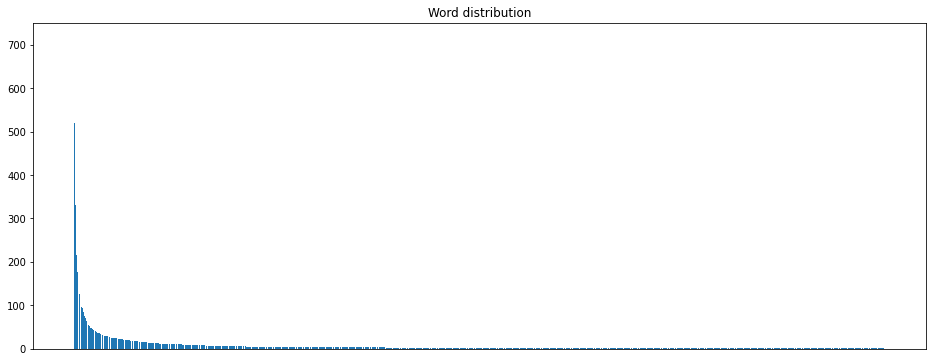

In [ ]:
# Count word frequencies
frequency = defaultdict(int)
for text in corpus:
    for token in text:
        frequency[token] += 1

#tmp = random.sample(list(frequency.keys()), 6000)
tmp = list(frequency.keys())
l2, l1 = zip(*sorted(zip([frequency[k] for k in tmp], tmp), reverse=True))
plt.figure(figsize=(16, 6))
plt.bar(l1, l2)
plt.xticks([])
plt.title('Word distribution')
plt.show()

In [ ]:
df['text'] = df.libelle_appellation_long.apply(lambda x:' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## **2.2 Train/test split**

In [ ]:
# Train/test split
df_train, df_test = train_test_split(df, stratify=df.code_grand_domaine, 
                                     random_state=42, test_size=0.30, 
                                     shuffle=True)
x_train, y_train = df_train.libelle_appellation_long.values, df_train.code_grand_domaine.values
x_test, y_test = df_test.libelle_appellation_long.values, df_test.code_grand_domaine.values
print(f"Train dataset has {len(df_train)} documents")
print(f"Test dataset has {len(df_test)} documents")

Train dataset has 7778 documents
Test dataset has 3334 documents


# **3. Basic and classic models**

## **3.1 Model based on words frequency**

The simplest model that can be used is the one based on the words frequency of each category. Here we try to label a job by looking at the number of common most frequent words of each categories. Its main drawback is when there is an equality between several categories, or even no words in common, and that the choice includes randomness.

An easy upgrade of this method could also use n-grams, but it remains a baseline score to be compared with more advanced methods.

In [ ]:
word_counts = Counter(" ".join(df.text.values).split())
word_counts.most_common(10)

[('responsable', 715),
 ('chef', 683),
 ('technicien', 671),
 ('technicienne', 671),
 ('industrie', 618),
 ('conducteur', 520),
 ('conductrice', 519),
 ('agent', 468),
 ('agente', 465),
 ('ingénieur', 356)]

As an example, let's keep the 50 most frequent words of each category.

In [ ]:
top_k = 50
counters_domain = df.groupby("code_grand_domaine").apply(lambda subf: Counter(" ".join(subf.text.values).split()))

In [ ]:
most_common = counters_domain.apply(lambda cnt: [x[0] for x in cnt.most_common(top_k)])
most_common

code_grand_domaine
0     [ouvrier, ouvrière, production, agricole, élev...
1     [art, peintre, restaurateur, restauratrice, gr...
2     [assurance, responsable, immobilier, chargé, c...
3     [vendeur, vendeuse, commercial, commerciale, r...
4     [conducteur, conductrice, graphique, industrie...
5     [conducteur, conductrice, poseur, poseuse, che...
6     [animateur, animatrice, directeur, directrice,...
7     [industrie, technicien, technicienne, conducte...
8     [maintenance, technicien, technicienne, mécani...
9     [infirmier, infirmière, médecin, médicale, aid...
10    [agent, agente, responsable, directeur, direct...
11    [spectacle, chef, assistant, assistante, film,...
12    [responsable, informatique, directeur, directr...
13    [conducteur, conductrice, transport, agent, ag...
dtype: object

In [ ]:
counters_domain.apply(lambda cnt: len(cnt))

code_grand_domaine
0      643
1      460
2      320
3      615
4      600
5      784
6      496
7     1859
8      599
9      313
10    1344
11     506
12     735
13     589
dtype: int64

In [ ]:
# Percentage of Unique Words in this division 
all_words = [j for i in most_common.values for j in i]
len(np.unique(all_words))/len(all_words)

0.6514285714285715

There's at least 300 unique words per category, and the top ones are quite different, as there are around 65% of unique words across all categories.

That might only work for the 'grand domaine' only, since they are very high level labelings. The higher the number of words retained, the lower the percentage of unique words.

Also, as there is the female and male declibation of most words, one might think that the top terms are mostly duplicates across the lists.

Let's build the model to assess its performance.

In [ ]:
def mf_model(words_list, most_common):
    preds = most_common.apply(lambda mc: len([x for x in words_list if x in mc]))
    return(preds[preds==preds.max()].sample().index[0], len(preds[preds==preds.max()]))

def mf_model_test(top_k = 50):
    most_common = df.groupby("code_grand_domaine").apply(lambda subf: [x[0] for x in Counter(" ".join(subf.text.values).split()).most_common(top_k)])

    all_words = [j for i in most_common.values for j in i]
    print("{:.02%} of words are unique".format(len(np.unique(all_words))/len(all_words)))
    
    predictions = []
    random_preds = []
    for i in range(len(df)):
        pred, prob = mf_model(df.libelle_appellation_long.iloc[i], most_common)
        predictions.append(pred)
        random_preds.append(prob)
    
    plt.title('Number of choices for the top category')
    plt.hist(random_preds, bins=len(encoder.classes_), density=True)
    
    print("weighted f1_score: %0.3f " % f1_score(df.code_grand_domaine, predictions, average="weighted"))
    plot_confusion_matrix(confusion_matrix(df.code_grand_domaine, predictions), target_names=encoder.classes_)

65.14% of words are unique
weighted f1_score: 0.524 


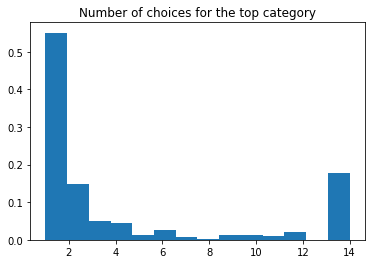

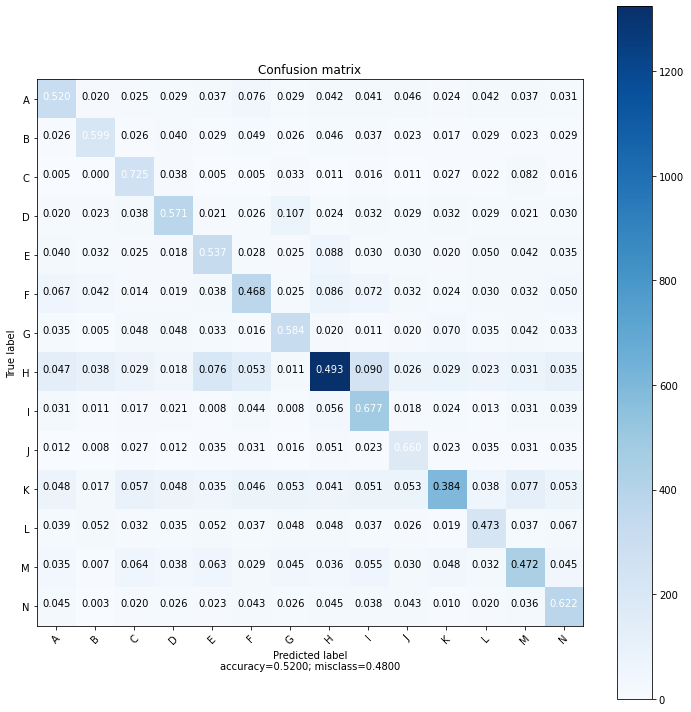

In [ ]:
mf_model_test(50)

63.17% of words are unique
weighted f1_score: 0.722 


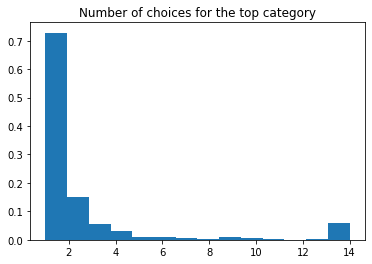

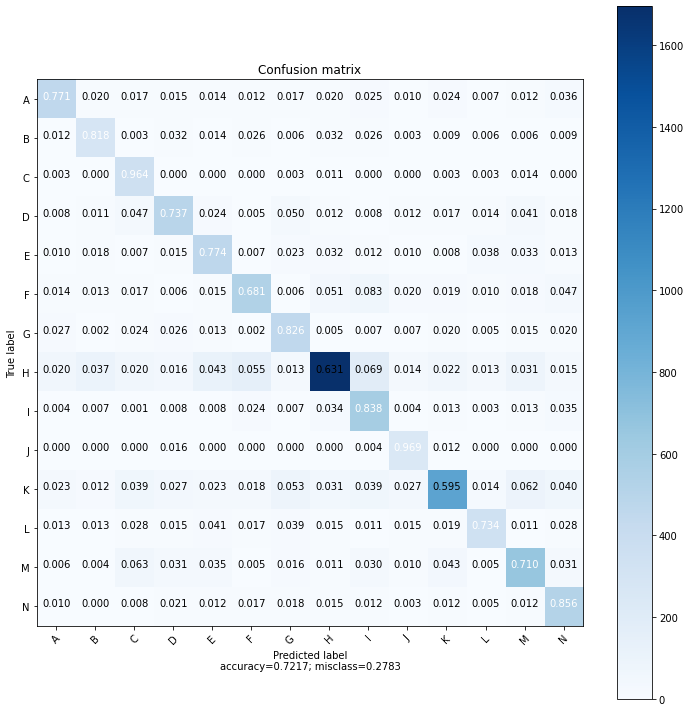

In [ ]:
mf_model_test(300)

This model provides a baseline score with an accuracy of 0.72 and a weighted f1_score of 0.720. 


## **3.2 BOW + Classification models (logreg, svm, decision trees)**

A more complete model is based on the Bag-Of-Word representation of a job title, on which a classification algorithm can directly work. Here we test a few classical models and evaluate them on different metrics to have insight on their relative performances. Without much hyperparameter tuning, the Logistic Regression seems to work a bit better than the others.

However, it is hard to evaluate qualitatively the performance of those models on new job titles because it would necessarily require to exclude all out-of-vocabulary words, and therefore any job title requalification would use the same words as the original job title. Another consequence is that a new job can't be easily added to this classifier, and would need a new training including that new vocabulary.

In [ ]:
x_train, y_train = df_train.text, df_train.code_grand_domaine.values
x_test, y_test = df_test.text, df_test.code_grand_domaine.values

ctv = CountVectorizer()
ctv.fit(df.text)

x_train_ctv =  ctv.transform(x_train) 
x_test_ctv = ctv.transform(x_test)

In [ ]:
clf_list = print_scores_models([LogisticRegression(max_iter = 300), SVC(probability=True), DecisionTreeClassifier(max_depth=500), MultinomialNB()],
                                x_train_ctv, x_test_ctv, y_train, y_test)

                    |       LogisticRegression|                      SVC|   DecisionTreeClassifier|            MultinomialNB
      micro f1_score|                    0.781|                    0.718|                    0.651|                    0.721
      macro f1_score|                    0.764|                    0.693|                    0.635|                    0.691
   weighted f1_score|                    0.783|                    0.717|                    0.663|                    0.715
             logloss|                    0.801|                    0.854|                    8.885|                    0.936
            accuracy|                    0.781|                    0.718|                    0.651|                    0.721


## **3.3 tf-idf + Classification models**

Similarly as the previous subsection, we use the previous protocol but with a tf-idf document representation this time. Here, it is the SVC that has the best performances.

The conclusions are the same as the previous ones : it is hard to adapt to new job titles.

In [ ]:
x_train, y_train = df_train.text, df_train.code_grand_domaine.values
x_test, y_test = df_test.text, df_test.code_grand_domaine.values

tfv = TfidfVectorizer()
tfv.fit(df.text)

x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

In [ ]:
clf_list = print_scores_models([LogisticRegression(max_iter = 300), SVC(probability=True), DecisionTreeClassifier(max_depth=500), MultinomialNB()],
                               x_train_tfv, x_test_tfv, y_train, y_test)

                    |       LogisticRegression|                      SVC|   DecisionTreeClassifier|            MultinomialNB
      micro f1_score|                    0.744|                    0.757|                    0.620|                    0.636
      macro f1_score|                    0.719|                    0.741|                    0.597|                    0.567
   weighted f1_score|                    0.740|                    0.754|                    0.626|                    0.618
             logloss|                    1.052|                    0.704|                    9.914|                    1.242
            accuracy|                    0.744|                    0.757|                    0.620|                    0.636


# **4. Advanced methods**

The previous models were too simple and rigid to be used with some interaction. In this section, we try different models based on more advanced word and document representations.

## **4.1 Training embeddings (Word2Vec) for classification using an aggregation method**

A common model to represent words in Word2Vev. It is here trained on the vocabulary contained in the dataset only. The embedding for a job title is then built by aggregating its words' embbedings. Here, the aggregation method chosen is the average. One can also choose different methods such as max for example.

In [ ]:
x = list(df.libelle_appellation_long.values)
model = Word2Vec(x, size=100, window=5, min_count=1)
model.train(x, total_examples=len(x), epochs=10)

(386378, 445610)

The next cell enables to see the most similar words of the input. It is not very relevant, except in some case.

In [ ]:
model.wv.most_similar('autruches', topn=10)

[('cervidés', 0.6263222694396973),
 ('ânes', 0.6165673732757568),
 ('chat', 0.5911886692047119),
 ('bovins', 0.5428924560546875),
 ('agneaux', 0.5037039518356323),
 ('bison', 0.4910407066345215),
 ('crocodile', 0.46932774782180786),
 ('chèvres', 0.36394280195236206),
 ('brebis', 0.33127033710479736),
 ('combiné', 0.3175249695777893)]

In [ ]:
model.wv.vectors.shape

(6033, 100)

In [ ]:
embedded_docs_wv = np.zeros((len(df), model.vector_size))
for i, sentence in enumerate(df.libelle_appellation_long.values):
  embedded_docs_wv[i] = np.mean([model.wv[x] for x in sentence], axis=0)

In [ ]:
embeddings_wv_train = embedded_docs_wv[df_train.index.values]
embeddings_wv_test = embedded_docs_wv[df_test.index.values]

In [ ]:
clf_list = print_scores_models([LogisticRegression(max_iter = 400), SVC(probability=True), DecisionTreeClassifier(max_depth=500), RandomForestClassifier()], 
                               embeddings_wv_train, embeddings_wv_test, y_train, y_test)

                    |       LogisticRegression|                      SVC|   DecisionTreeClassifier|   RandomForestClassifier
      micro f1_score|                    0.485|                    0.455|                    0.440|                    0.568
      macro f1_score|                    0.336|                    0.293|                    0.378|                    0.503
   weighted f1_score|                    0.437|                    0.401|                    0.441|                    0.560
             logloss|                    1.656|                    1.669|                   19.331|                    2.062
            accuracy|                    0.485|                    0.455|                    0.440|                    0.568


As word embeddings are quite difficult to understand numerically, one way to visualize the knowledge learnt is to use a t-SNE. This projection method will help visualize clusters of documents of they are evident. However, the following projection doesn't show a lot of coherent clusters. This is the consequence of using pretrained embeddings, that do not necessarily represent well the dataset vocabulary.

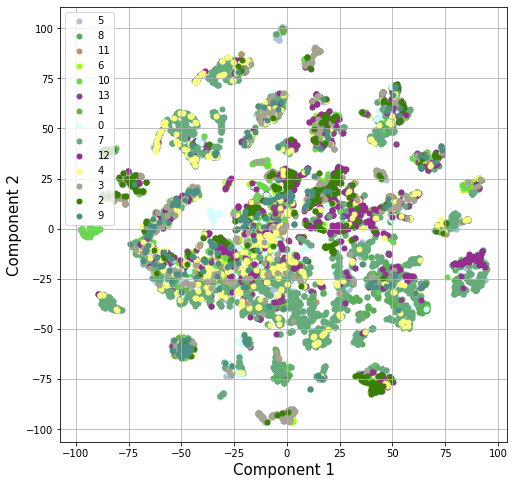

In [ ]:
tsne_embeddings(embedded_docs_wv)

Nevertheless, let's try to classify out of dataset job titles. Some are close to the ones used in the dataset vocabulary, but use different descriptions. A basic research in the dataset doesn't give a good result and this would need a more complex research system.

For example, the closest dataset job title to `présentateur journal télévisé` is `présentateur présentatrice émission TV`, and `responsable garde accueil gestion immeuble` is a definition for `concierge`.

In [ ]:
new_job_titles = ["présentateur journal télévisé", "présentateur bulletin météo", "animateur centre loisirs pour enfant", "responsable garde accueil gestion immeuble"]
new_job_titles_expected = ["E", "E", "G", "K"]

In [ ]:
model_wv_vocab = list(model.wv.vocab.keys())

embedded_new_job_titles = np.zeros((len(new_job_titles), model.vector_size))
for i, sentence in enumerate(new_job_titles):
  sentence_vector = [model.wv[x] for x in sentence.split() if x in model_wv_vocab]
  if len(sentence_vector)>0:
    embedded_new_job_titles[i] = np.mean(sentence_vector, axis=0)

print_new_jobs(embedded_new_job_titles, new_job_titles, new_job_titles_expected, clf_list)

*** Expected ***
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité


--- LogisticRegression ---
	 * présentateur journal télévisé                 : Services à la personne et à la collectivité
	 * présentateur bulletin météo                   : Services à la personne et à la collectivité
	 * animateur centre loisirs pour enfant          : Services à la personne et à la collectivité
	 * responsable garde accueil gestion immeuble    : Support à l'entreprise
	 Success rate : 0/4


--- SVC ---
	 * présentateur journal télévisé                 : Services à la personne et à la collectivité
	 * présentateur bulletin météo                   : Services à la personne et à la

## **4.2 Classification using pretrained embeddings**

As job titles are very short, they lack context to be trained. Therefore, importing pretrained embeddings has the advantage to add knowledge extracted from a way larger dataset.

The pretrained word2vec embeddings are taken from [here](https://fauconnier.github.io/#data). The dataset is then converted using the same method as the previous subsection, provided that the words are in the pretrained model vocabulary.



In [ ]:
!wget -q https://s3.us-east-2.amazonaws.com/embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin

In [ ]:
model = KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin", binary=True, unicode_errors="ignore")

In [ ]:
model_vocab = list(model.vocab.keys())
dataset_vocab = list(dictionary.values())

print("Coverage of the dataset vocabulary by the pretrained model : {:.02%}".format(len([x for x in dataset_vocab if x in model_vocab])/len(dataset_vocab)))

Coverage of the dataset vocabulary by the pretrained model : 71.44%


In [ ]:
embedded_docs = np.zeros((len(df), model.vector_size))
for i, sentence in enumerate(df.libelle_appellation_long.values):
  sentence_vector = [model.get_vector(x) for x in sentence if x in model_vocab]
  if len(sentence_vector)>0:
    embedded_docs[i] = np.mean(sentence_vector, axis=0)

In [ ]:
embeddings_train = embedded_docs[df_train.index.values]
embeddings_test = embedded_docs[df_test.index.values]

In [ ]:
clf_list = print_scores_models([LogisticRegression(max_iter = 300), SVC(probability=True), DecisionTreeClassifier(max_depth=500), RandomForestClassifier()], 
                               embeddings_train, embeddings_test, y_train, y_test)

                    |       LogisticRegression|                      SVC|   DecisionTreeClassifier|   RandomForestClassifier
      micro f1_score|                    0.765|                    0.799|                    0.488|                    0.735
      macro f1_score|                    0.751|                    0.788|                    0.440|                    0.723
   weighted f1_score|                    0.763|                    0.798|                    0.485|                    0.731
             logloss|                    0.894|                    0.701|                   16.577|                    1.199
            accuracy|                    0.765|                    0.799|                    0.488|                    0.735


Here again, no cluster can be identified from the t-SNE.

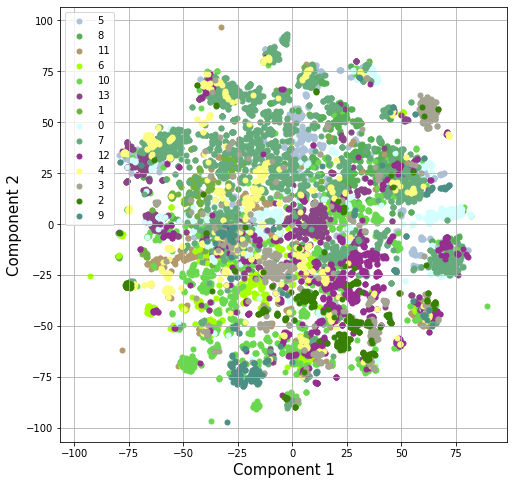

In [ ]:
tsne_embeddings(embedded_docs)

Let's try to classify the same previous out of dataset job titles.

In [ ]:
embedded_new_job_titles = np.zeros((len(new_job_titles), model.vector_size))
for i, sentence in enumerate(new_job_titles):
  sentence_vector = [model.get_vector(x) for x in sentence.split() if x in model_vocab]
  if len(sentence_vector)>0:
    embedded_new_job_titles[i] = np.mean(sentence_vector, axis=0)

print_new_jobs(embedded_new_job_titles, new_job_titles, new_job_titles_expected, clf_list)

*** Expected ***
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité


--- LogisticRegression ---
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité
	 Success rate : 4/4


--- SVC ---
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et 

## **4.3 Training Doc2Vec for classification**

The previous aggregation method isn't the most suitable for representing documents. In this section, we use Doc2Vec, which is similar to Word2Vec except that it directly builds embeddings for the documents.

In [ ]:
model_d2v = Doc2Vec(vector_size=200, min_count=1, epochs=200, workers=2)
docs_d2v = [TaggedDocument(txt, [i]) for i, txt in enumerate(list(df.libelle_appellation_long.values))]
model_d2v.build_vocab(docs_d2v)
model_d2v.train(docs_d2v, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

Predicting on a training document gives a relevant most similar document, and the results of predicting on an unseen document kind of make sense. The most similar documents are the ones containing similar main words, but not necessarily the same sense.

In [ ]:
for new_job in new_job_titles:
  print(f" --- {new_job} --- ")
  vector = model_d2v.infer_vector(new_job.split())
  for id, proba in model_d2v.docvecs.most_similar([vector], topn=3):
    print("   * {:60} : {}".format(df.text.iloc[id], proba))
  print("\n")

 --- présentateur journal télévisé --- 
   * journaliste présentateur présentatrice radio                 : 0.9462244510650635
   * présentateur présentatrice radio                             : 0.9412153959274292
   * présentateur présentatrice spectacle                         : 0.9359520673751831


 --- présentateur bulletin météo --- 
   * présentateur présentatrice tv                                : 0.6819052696228027
   * journaliste présentateur présentatrice tv                    : 0.6720105409622192
   * observateur observatrice nivo météorologiste                 : 0.6562291383743286


 --- animateur centre loisirs pour enfant --- 
   * conseiller vendeur conseillère vendeuse véhicules loisirs    : 0.5118799805641174
   * employé employée parc loisirs                                : 0.4642387628555298
   * animateur animatrice accueil loisirs centre loisirs          : 0.462604284286499


 --- responsable garde accueil gestion immeuble --- 
   * responsable commercial commer

In [ ]:
embedded_docs_dv = np.zeros((len(df), model_d2v.vector_size))
for i, sentence in enumerate(df.libelle_appellation_long.values):
  embedded_docs_dv[i] = model_d2v.infer_vector(sentence)

In [ ]:
embeddings_dv_train = embedded_docs_dv[df_train.index.values]
embeddings_dv_test = embedded_docs_dv[df_test.index.values]

In [ ]:
clf_list = print_scores_models([LogisticRegression(max_iter = 300), SVC(probability=True), DecisionTreeClassifier(max_depth=500), RandomForestClassifier()], 
                               embeddings_dv_train, embeddings_dv_test, y_train, y_test)

                    |       LogisticRegression|                      SVC|   DecisionTreeClassifier|   RandomForestClassifier
      micro f1_score|                    0.448|                    0.540|                    0.265|                    0.478
      macro f1_score|                    0.407|                    0.486|                    0.209|                    0.392
   weighted f1_score|                    0.436|                    0.528|                    0.266|                    0.447
             logloss|                    1.778|                    1.518|                   25.381|                    1.813
            accuracy|                    0.448|                    0.540|                    0.265|                    0.478


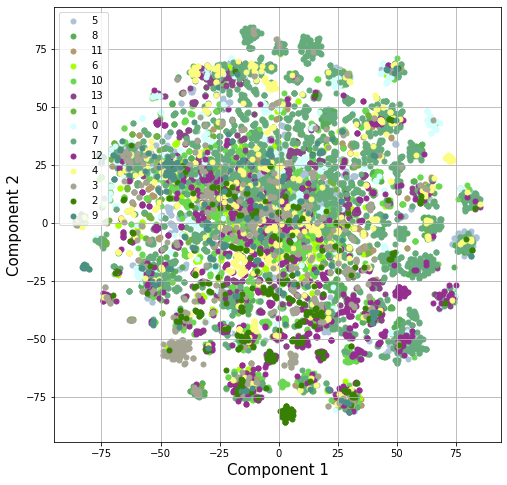

In [ ]:
tsne_embeddings(embedded_docs_dv)

In [ ]:
embedded_new_job_titles_dv = np.zeros((len(new_job_titles), model_d2v.vector_size))
for i, sentence in enumerate(new_job_titles):
  embedded_new_job_titles_dv[i] = model_d2v.infer_vector(sentence.split())

print_new_jobs(embedded_new_job_titles_dv, new_job_titles, new_job_titles_expected, clf_list)

*** Expected ***
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité


--- LogisticRegression ---
	 * présentateur journal télévisé                 : Spectacle
	 * présentateur bulletin météo                   : Spectacle
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Construction, Bâtiment et Travaux publics
	 Success rate : 1/4


--- SVC ---
	 * présentateur journal télévisé                 : Spectacle
	 * présentateur bulletin météo                   : Industrie
	 * animateur centre loisirs pour enfant          : Industrie
	 * responsable garde accueil

The previous classification algorithms didn't improve the best models yet achieved. Moreover, simply taking the class of the most similar item in the training set doesn't perform well either.

However, until now, we only used the job titles themselves for classification, but each class has a textual description that could be added to the learnt data. For example, each ROME code has a description like the following one :

In [ ]:
print(f"Shape : {df_texte[df_texte.code_type_texte == 1].libelle_texte.shape}")
print(f"Example : {df_texte[df_texte.code_type_texte == 1].libelle_texte.sample().values[0]}")

Shape : (1502,)
Example : Met en place les mesures correctives en cas d''irrégularité (amendes, procès-verbaux, ...) selon la réglementation, dans un objectif de sécurité des passagers et de sauvegarde des recettes et biens de l''entreprise.


Let's preprocess them and group them in one of the 14 classes. We will then train a doc2vec model on each grouped description, and infer vectors for each job title. Those job title vectors will then be assigned the most similar document class.

In [ ]:
with pd.option_context('mode.chained_assignment', None):
    df_texte['libelle_texte'] = lowerize(df_texte.libelle_texte)
    df_texte['libelle_texte'] = tokenize(df_texte.libelle_texte)
    df_texte['libelle_texte'] = remove_stop_words(df_texte.libelle_texte)
    df_texte['libelle_texte'] = remove_word_with_length(df_texte.libelle_texte)
    df_texte['libelle_texte'] = lemmatize(df_texte.libelle_texte)

In [ ]:
df_texte.code_rome = df_texte.code_rome.apply(lambda x: x[0])

In [ ]:
text_per_class = df_texte.groupby("code_rome").apply(lambda sub: list(sub['libelle_texte'].apply(lambda x: " ".join(x)).values))

In [ ]:
model_dv_class = Doc2Vec(vector_size=50, min_count=1, epochs=100, workers=2)
docs_dv_class = []
for i, txts in enumerate(text_per_class):
  for txt in txts:
    docs_dv_class.append(TaggedDocument(txt, [i]))
model_dv_class.build_vocab(docs_dv_class)
model_dv_class.train(docs_dv_class, total_examples=model_dv_class.corpus_count, epochs=model_dv_class.epochs)

Unfortunately, this doesn't give any good result. This is probably due to the difference in vocabulary of the two datasets. Class descriptions are action oriented ("Peut présenter") and the job titles are more descriptive ("présentateur"), which creates a difference in the vocabulary used.

In [ ]:
sample = df.libelle_appellation_long.sample().values[0]

print(f" --- {sample} --- ")
vector = model_dv_class.infer_vector(sample)
for id, proba in model_dv_class.docvecs.most_similar([vector], topn=3):
  print("   * {:60} : {}".format(df_niv1.libelle_grand_domaine.iloc[id], proba))
print("\n")

 --- ['chef', 'équipe', 'maintenance', 'ascenseurs'] --- 
   * Santé                                                        : 0.33415088057518005
   * Installation et Maintenance                                  : 0.25525349378585815
   * Services à la personne et à la collectivité                  : 0.17400482296943665




In [ ]:
for new_job in new_job_titles:
  print(f" --- {new_job} --- ")
  vector = model_dv_class.infer_vector(new_job.split())
  for id, proba in model_dv_class.docvecs.most_similar([vector], topn=3):
    print("   * {:60} : {}".format(df_niv1.libelle_grand_domaine.iloc[id], proba))
  print("\n")

 --- présentateur journal télévisé --- 
   * Services à la personne et à la collectivité                  : 0.3814740777015686
   * Hôtellerie-Restauration, Tourisme, Loisirs et Animation      : 0.24949264526367188
   * Agriculture et Pêche, Espaces naturels et Espaces verts, Soins aux animaux : 0.18790043890476227


 --- présentateur bulletin météo --- 
   * Spectacle                                                    : 0.2824687063694
   * Installation et Maintenance                                  : 0.24173837900161743
   * Agriculture et Pêche, Espaces naturels et Espaces verts, Soins aux animaux : 0.21010971069335938


 --- animateur centre loisirs pour enfant --- 
   * Santé                                                        : 0.16392071545124054
   * Transport et Logistique                                      : 0.1128142774105072
   * Communication, Média et Multimédia                           : 0.03724145516753197


 --- responsable garde accueil gestion immeuble --- 
  

## **4.4 Seq2Seq model with embedding layer**

In this section, we try a neural network to solve this task. In prticular, we use a LSTM as the main component, while keeping the network simple. It achieves good results quickly but fails to overperform other models.

Inspired from : https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5

In [ ]:
with pd.option_context('mode.chained_assignment', None):
  df_lstm = df[["libelle_appellation_long", "code_grand_domaine"]]
  df_lstm.columns = ["text", "label"]
  df_lstm["text_len"] = df_lstm["text"].apply(len)

In [ ]:
vocab2index = {"":0, "UNK":1}
for w, id in dictionary.token2id.items():
  vocab2index[w] = id+2

In [ ]:
def encode_sentence(words_list, vocab2index, N=20):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in words_list])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
max_seq_len = df_lstm.text_len.max()
with pd.option_context('mode.chained_assignment', None):
  df_lstm['encoded'] = df_lstm['text'].apply(lambda x: np.array(encode_sentence(x, vocab2index, max_seq_len)))
df_lstm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


,text,label,text_len,encoded
0,"[abatteur, abatteuse, carrière]",5,3,"[[2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3]"
1,"[accastilleur, gréeur, accastilleuse, gréeuse]",8,4,"[[5, 7, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4]"
2,"[accastilleur, monteur, accastilleuse, monteus...",8,6,"[[5, 10, 6, 11, 12, 9, 0, 0, 0, 0, 0, 0, 0], 6]"
3,[accessoiriste],11,1,"[[13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]"
4,"[accessoiriste, plateau]",11,2,"[[13, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2]"


In [ ]:
X_train = list(df_lstm['encoded'].iloc[df_train.index])
X_test = list(df_lstm['encoded'].iloc[df_test.index])

In [ ]:
class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

def train_model(model, train_dl, test_dl, epochs=10):
    for i in range(epochs + 1):
        if (i == int(epochs/3)) or (i == int(2*epochs/3)):
            for g in optimizer.param_groups:
                g['lr'] = g['lr'] / 10
                print(" ** Learning rate decreased to : ", g['lr'])
        model.train()
        sum_loss = 0.0
        correct = 0
        total = 0
        for x, y, l in train_dl:
            if torch.cuda.is_available():
                x = x.type(torch.cuda.LongTensor)
                y = y.type(torch.cuda.LongTensor)
            else:
                x = x.long()
                y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            pred = torch.max(y_pred, 1)[1]
            correct += (pred == y).float().sum()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = validation_metrics(model, test_dl)
        if i % 5 == 0:
            print("Epoch {:>2} : train loss {:0.3f}, val loss {:0.3f} -- train accuracy {:0.3f}, val accuracy {:0.3f}".format(i, sum_loss/total, val_loss, correct/total, val_acc))

def validation_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in test_dl:
        if torch.cuda.is_available():
                x = x.type(torch.cuda.LongTensor)
                y = y.type(torch.cuda.LongTensor)
        else:
                x = x.long()
                y = y.long()
        y_hat = model(x, l)
        loss = loss_fn(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [ ]:
class LSTMClassifier(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, hidden_layers=2, dropout_keep=.2) :
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=hidden_layers)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(dropout_keep)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
batch_size = 64
vocab_size = len(vocab2index)
embedding_dim = 128
hidden_dim = 64
hidden_layers=2
output_size = df_lstm.label.nunique()
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_size, hidden_layers)
if torch.cuda.is_available():
    model.cuda()

train_dl = DataLoader(Dataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(Dataset(X_test, y_test), batch_size=batch_size)

lr = 0.01
parameters = filter(lambda p: p.requires_grad, model.parameters())

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(parameters, lr=lr)

In [ ]:
train_model(model, train_dl, test_dl, epochs=80)

Epoch  0 : train loss 2.153, val loss 1.890 -- train accuracy 0.310, val accuracy 0.385
Epoch  5 : train loss 0.577, val loss 1.089 -- train accuracy 0.828, val accuracy 0.717
Epoch 10 : train loss 0.216, val loss 1.096 -- train accuracy 0.934, val accuracy 0.757
Epoch 15 : train loss 0.133, val loss 1.177 -- train accuracy 0.957, val accuracy 0.763
Epoch 20 : train loss 0.098, val loss 1.212 -- train accuracy 0.970, val accuracy 0.771
Epoch 25 : train loss 0.076, val loss 1.272 -- train accuracy 0.974, val accuracy 0.775
 ** Learning rate decreased to :  0.001
Epoch 30 : train loss 0.043, val loss 1.295 -- train accuracy 0.987, val accuracy 0.775
Epoch 35 : train loss 0.035, val loss 1.317 -- train accuracy 0.989, val accuracy 0.779
Epoch 40 : train loss 0.029, val loss 1.338 -- train accuracy 0.992, val accuracy 0.781
Epoch 45 : train loss 0.020, val loss 1.361 -- train accuracy 0.994, val accuracy 0.783
Epoch 50 : train loss 0.020, val loss 1.380 -- train accuracy 0.995, val accurac

In [ ]:
model.eval()
y_true = []
y_preds = []
predictions = []
for x, y, l in test_dl:
    if torch.cuda.is_available():
            x = x.type(torch.cuda.LongTensor)
            y = y.type(torch.cuda.LongTensor)
    else:
            x = x.long()
            y = y.long()
    y_hat = model(x, l)
    preds = torch.max(y_hat, 1)
    y_true.extend(y.cpu().numpy())
    y_preds.extend(preds[1].cpu().detach().numpy())

print("f1 micro :", f1_score(y_test, y_preds, average="micro"))
print("f1 macro :", f1_score(y_test, y_preds, average="macro"))
print("f1 weighted :", f1_score(y_test, y_preds, average="weighted"))
#print(multiclass_logloss(y_test, predictions))
print("Accuracy :", accuracy_score(y_test, y_preds))

f1 micro : 0.7795440911817636
f1 macro : 0.7448908429207531
f1 weighted : 0.7799716647654207
Accuracy : 0.7795440911817636


Now let's try the new job titles. The main problem here is the limited vocabulary again. But this can be overcome by using pretrained embeddings like it was done previously.

In [ ]:
print("*** Expected ***")
for i, job_title in enumerate(new_job_titles):
    print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == new_job_titles_expected[i]].libelle_grand_domaine.values[0]))
print("\n")

input = [encode_sentence(seq.split(), vocab2index, N=max_seq_len) for seq in new_job_titles]
new_job_dl = DataLoader(Dataset(input, new_job_titles_expected), batch_size=1, shuffle=False)
model.cpu()

y_preds = []
for x, y, l in new_job_dl:
  y_hat = model(x, l)
  preds = torch.max(y_hat, 1)
  y_preds.extend(preds[1].detach().numpy())

print("--- LSTM RNN ---")
labels = encoder.inverse_transform(y_preds)
for i, job_title in enumerate(new_job_titles):
  print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == labels[i]].libelle_grand_domaine.values[0]))
print("\t Success rate : {}/{}".format(sum(np.array(labels) == np.array(new_job_titles_expected)), len(labels)))
print("\n")

*** Expected ***
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité


--- LSTM RNN ---
	 * présentateur journal télévisé                 : Spectacle
	 * présentateur bulletin météo                   : Spectacle
	 * animateur centre loisirs pour enfant          : Services à la personne et à la collectivité
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité
	 Success rate : 1/4




## **4.5 CamemBERT fine-tuning**

As a big enhancement of the previous model, we use here a pretrained BERT model in french, already built for sequence classification. The only step needed here is the finte tuning to our specific task. Ask it comes with a particular tokenizer, we use here the raw job titles.

In [ ]:
df_train.head()

,libelle_appellation_long,code_rome,code_domaine_professionel,code_grand_domaine,raw_text,text
933,"[armurier, armurière, fabrication]",H2901,H29,7,Armurier / Armurière de fabrication,armurier armurière fabrication
8063,"[régisseur, régisseuse, exposition]",K1602,K16,10,Régisseur / Régisseuse des expositions,régisseur régisseuse exposition
1865,"[chef, chantier, montage, structure, métalliques]",F1202,F12,5,Chef de chantier montage de structures métalli...,chef chantier montage structure métalliques
6744,"[opérateur, opératrice, affinage, métallurgie]",H2907,H29,7,Opérateur / Opératrice d'affinage en métallurgie,opérateur opératrice affinage métallurgie
6082,"[maquilleur, maquilleuse, spectacle]",L1501,L15,11,Maquilleur / Maquilleuse spectacle,maquilleur maquilleuse spectacle


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, maxlen, colname, model_name='camembert-base'):
        self.dataset = df
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.maxlen = maxlen
        self.colname = colname

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        sentence = self.dataset.iloc[index]['raw_text']
        label = self.dataset.iloc[index][self.colname]

        tokens = self.tokenizer.tokenize(sentence)
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token]
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token]

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != self.tokenizer.pad_token_id).long()

        return tokens_ids_tensor, attn_mask, label

In [ ]:
train_set = Dataset(df_train, maxlen = 20, colname = 'code_grand_domaine', model_name='camembert-base')
val_set = Dataset(df_test, maxlen = 20, colname = 'code_grand_domaine', model_name='camembert-base')

train_loader = DataLoader(train_set, batch_size = 64, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = 64, num_workers = 2)

In [ ]:
class SequenceClassifier(nn.Module):

    def __init__(self, pretrained_model_name='camembert-base', n_classes = 1):
        super(SequenceClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        self.drop = nn.Dropout(p=0.1)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, n_classes)

    def forward(self, seq, attn_masks):
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        pool = cont_reps["pooler_output"]
        pool = self.drop(pool)
        logits = self.cls_layer(pool)
        return logits

In [ ]:
sequence_model = SequenceClassifier('camembert-base', n_classes = df.code_grand_domaine.nunique())
sequence_model = sequence_model.to("cuda")

In [ ]:
max_eps = 4

criterion = nn.CrossEntropyLoss()
opti = optim.Adam(sequence_model.parameters(), lr = 1e-4)

total_steps = len(train_loader) * max_eps
scheduler = get_linear_schedule_with_warmup(opti, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
def train(model, criterion, opti, train_loader, val_loader, scheduler, max_eps=1, 
          gpu=True, print_every=1, validate_every=1, break_training_after=None):
    for ep in range(max_eps):
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()  

            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = model(seq, attn_masks)
            _, preds = torch.max(logits, dim=1)
            loss = criterion(logits, labels)
            loss.backward()
            opti.step()
            scheduler.step()
            if (it + 1) % print_every == 0:
                accuracy = torch.sum(preds==labels)/float(labels.size(0))
                print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
            if break_training_after is not None and it>break_training_after:
              print("Early breaking : did not cover a full epoch but only {} iteration ".format(it))
              break
        if ep % validate_every==0:
          n_batch_validation = 0
          loss_validation = 0
          accuracy_validation = 0
          for it, (seq, attn_masks, labels) in enumerate(val_loader):            
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits_val = model(seq, attn_masks)
            _, preds_val = torch.max(logits_val, dim=1)
            n_batch_validation+=1
            _loss = float(criterion(logits_val, labels))
            _accu = float(torch.sum(preds_val==labels)/float(labels.size(0)))
            
            loss_validation += _loss
            accuracy_validation += _accu
          print("EVALUATION Validation set : mean loss {} n mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))

In [ ]:
train(sequence_model, criterion, opti, train_loader, val_loader, scheduler, max_eps, print_every=25, gpu=True)

Iteration 25 of epoch 1 complete. Loss : 1.8800933361053467, Accuracy 0.625 
Iteration 50 of epoch 1 complete. Loss : 1.2920552492141724, Accuracy 0.6875 
Iteration 75 of epoch 1 complete. Loss : 0.9867979884147644, Accuracy 0.8125 
Iteration 100 of epoch 1 complete. Loss : 0.7934941649436951, Accuracy 0.84375 
EVALUATION Validation set : mean loss 0.7691088616847992 n mean accuracy 0.8028694976050899
Iteration 25 of epoch 2 complete. Loss : 0.5711773633956909, Accuracy 0.859375 
Iteration 50 of epoch 2 complete. Loss : 0.4290738105773926, Accuracy 0.90625 
Iteration 75 of epoch 2 complete. Loss : 0.2817237675189972, Accuracy 0.9375 
Iteration 100 of epoch 2 complete. Loss : 0.23033417761325836, Accuracy 0.953125 
EVALUATION Validation set : mean loss 0.6073803997264718 n mean accuracy 0.8376572334541464
Iteration 25 of epoch 3 complete. Loss : 0.2828255891799927, Accuracy 0.9375 
Iteration 50 of epoch 3 complete. Loss : 0.25078824162483215, Accuracy 0.953125 
Iteration 75 of epoch 3 c

In [ ]:
sequence_model.eval()
y_preds = []
for seq, attn_masks, labels in val_loader:
    if torch.cuda.is_available():
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
    logits_val = sequence_model(seq, attn_masks)
    _, preds_val = torch.max(logits_val, dim=1)
    y_preds.extend(preds_val.cpu().detach().numpy())

print("f1 micro :", f1_score(y_test, y_preds, average="micro"))
print("f1 macro :", f1_score(y_test, y_preds, average="macro"))
print("f1 weighted :", f1_score(y_test, y_preds, average="weighted"))
#print(multiclass_logloss(y_test, predictions))
print("Accuracy :", accuracy_score(y_test, y_preds))

f1 micro : 0.853629274145171
f1 macro : 0.8379562486501103
f1 weighted : 0.8534993240615516
Accuracy : 0.853629274145171


In [ ]:
print("*** Expected ***")
for i, job_title in enumerate(new_job_titles):
    print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == new_job_titles_expected[i]].libelle_grand_domaine.values[0]))
print("\n")

df_new_jobs = pd.DataFrame(np.array([new_job_titles, encoder.transform(new_job_titles_expected)]).T, columns=["raw_text", 'code_grand_domaine'])
ds_nj = Dataset(df_new_jobs, maxlen = 20, model_name='camembert-base')
new_job_dl = DataLoader(ds_nj, batch_size=4, shuffle =False)

y_preds = []
for (seq, attn_masks, labels) in new_job_dl:
    if torch.cuda.is_available():
            seq, attn_masks = seq.cuda(), attn_masks.cuda()
    logits_val = sequence_model(seq, attn_masks)
    _, preds_val = torch.max(logits_val, dim=1)
    y_preds.extend(preds_val.cpu().detach().numpy())

print("--- BERT ---")
labels = encoder.inverse_transform(y_preds)
for i, job_title in enumerate(new_job_titles):
  print("\t * {:45} : {}".format(job_title, df_niv1[df_niv1.code_grand_domaine == labels[i]].libelle_grand_domaine.values[0]))
print("\t Success rate : {}/{}".format(sum(np.array(labels) == np.array(new_job_titles_expected)), len(labels)))
print("\n")

*** Expected ***
	 * présentateur journal télévisé                 : Communication, Média et Multimédia
	 * présentateur bulletin météo                   : Communication, Média et Multimédia
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité


--- BERT ---
	 * présentateur journal télévisé                 : Spectacle
	 * présentateur bulletin météo                   : Support à l'entreprise
	 * animateur centre loisirs pour enfant          : Hôtellerie-Restauration, Tourisme, Loisirs et Animation
	 * responsable garde accueil gestion immeuble    : Services à la personne et à la collectivité
	 Success rate : 2/4




# **5. Higher number of classes**

Let's try the best method on a higher number of classes.

In [ ]:
# Encode label
encoder_dp = preprocessing.LabelEncoder()
df_train['code_domaine_professionel'] = encoder_dp.fit_transform(df_train.code_domaine_professionel.values)
df_test['code_domaine_professionel'] = encoder_dp.transform(df_test.code_domaine_professionel.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_set = Dataset(df_train, maxlen = 20, colname = 'code_domaine_professionel', model_name='camembert-base')
val_set = Dataset(df_test, maxlen = 20, colname = 'code_domaine_professionel', model_name='camembert-base')

train_loader = DataLoader(train_set, batch_size = 32, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 2)

In [ ]:
print(df.code_domaine_professionel.nunique())
sequence_model = SequenceClassifier('camembert-base', n_classes = df.code_domaine_professionel.nunique())
sequence_model = sequence_model.to("cuda")

110


In [ ]:
max_eps = 5

criterion = nn.CrossEntropyLoss()
opti = optim.Adam(sequence_model.parameters(), lr = 1e-4)

total_steps = len(train_loader) * max_eps
scheduler = get_linear_schedule_with_warmup(opti, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
train(sequence_model, criterion, opti, train_loader, val_loader, scheduler, max_eps, print_every=25, gpu=True)

Iteration 25 of epoch 1 complete. Loss : 4.4739532470703125, Accuracy 0.125 
Iteration 50 of epoch 1 complete. Loss : 3.987797498703003, Accuracy 0.375 
Iteration 75 of epoch 1 complete. Loss : 3.7458832263946533, Accuracy 0.4375 
Iteration 100 of epoch 1 complete. Loss : 3.7818071842193604, Accuracy 0.1875 
Iteration 125 of epoch 1 complete. Loss : 3.3408918380737305, Accuracy 0.375 
Iteration 150 of epoch 1 complete. Loss : 3.175140142440796, Accuracy 0.4375 
Iteration 175 of epoch 1 complete. Loss : 3.009352207183838, Accuracy 0.4375 
Iteration 200 of epoch 1 complete. Loss : 3.013475179672241, Accuracy 0.34375 
Iteration 225 of epoch 1 complete. Loss : 2.5691497325897217, Accuracy 0.5625 
EVALUATION Validation set : mean loss 2.426086840175447 n mean accuracy 0.5106150794596899
Iteration 25 of epoch 2 complete. Loss : 2.004267692565918, Accuracy 0.65625 
Iteration 50 of epoch 2 complete. Loss : 1.6786370277404785, Accuracy 0.6875 
Iteration 75 of epoch 2 complete. Loss : 1.57151901

In [ ]:
sequence_model.eval()
y_preds = []
y_true = []
for seq, attn_masks, labels in val_loader:
    if torch.cuda.is_available():
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
    logits_val = sequence_model(seq, attn_masks)
    _, preds_val = torch.max(logits_val, dim=1)
    y_preds.extend(preds_val.cpu().detach().numpy())
    y_true.extend(labels.cpu().numpy())

print("f1 micro :", f1_score(y_true, y_preds, average="micro"))
print("f1 macro :", f1_score(y_true, y_preds, average="macro"))
print("f1 weighted :", f1_score(y_true, y_preds, average="weighted"))
#print(multiclass_logloss(y_test, predictions))
print("Accuracy :", accuracy_score(y_true, y_preds))

f1 micro : 0.7660467906418718
f1 macro : 0.650360269131956
f1 weighted : 0.7546305392255137
Accuracy : 0.7660467906418716
